---
# Modelling hippocampal neurons of animals <br> navigating in VR with recurrent neural networks
### Marco P. Abrate, Daniel Liu &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; University College London (UCL)
---

#### Outline
**Part 1: Rat simulation in 3D**
- Motion model with `RatInABox`

- Environment design

- Simulated rat vision with `ratvision`

**Part 2: Vision autoencoder**

**Part 3: Hippocampus model with RNN**

**Part 4: Hidden state representations analysis**
- Rate maps

- Polar maps

- Quantitive metrics

- Comparison with *in vivo* recordings

---
## **Part 3: Hippocampus model with RNN**
In this notebook, we will define the **Recurrent Neural Network (RNN)**, which will serve as a model of the hippocampus.

In the hippocampal formation, various classes of spatially modulated neurons support navigation by integrating sensory inputs to construct flexible internal models of the world [1,2]. Vision, in particular, plays a crucial role in guiding movement and shaping neural representations of space [3-5].

Recent computational approaches have demonstrated considerable success in modelling this ego-to-allocentric transformation using RNNs trained on self-supervised **predictive tasks**. Multiple studies suggest that predictive learning &mdash; anticipating future sensory inputs based on current and past observations &mdash; may be a fundamental computational principle underlying the emergence of spatial representations in both artificial systems and biological brains [6-11].

Before starting this notebook, make sure you have:
- trajectory data from part 1, including speed and rotational speed.
- vision data (frames) from part 1.
- embedded vision data from the Vision Autoencoder we trained in part 2.


### 0. Install and import dependencies

In [1]:
!pip install torch torchvision torchaudio
!pip install numpy
!pip install matplotlib

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### 1. Load trajectories and embeddings

We load embeddings of vision data recorded from the simulated rat, which we generated in part 2 using the Vision Autoencoder.

We load trajectories &mdash; made of x-y positions, head directions, velocities, and rotational velocities.

We subsample the data in order to have a temporal gap of one second between samples and increase the complexity of the predictive task.

In [3]:
# our trajectories are at 10 FPS
# we want to subsample them to 1 FPS
STRIDE = 10

In [4]:
d = '../data/adult'
trial_paths = sorted([p for p in Path(d).iterdir() if 'exp' in p.name])
trial_paths

[PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed01'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed02'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed03'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed04'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed05'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed06'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed07'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed08'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed09'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed10'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed11'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed12'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed13'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed14'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed15'),
 PosixPath('../data/adult/exp_dim0.635_fps10_s720_seed16'),
 PosixPath('../data/adult/exp_dim0.635_f

Import the function to subsample the data. Velocities must be integrated!

In [5]:
from utils import create_multiple_subsampling

Load trajectories and embeddings which will be used for training.

In [6]:

train_embeddings = []
train_vel, train_rotvel, train_pos, train_hds = [], [], [], []

for idx in range(20):
    tp = trial_paths[idx]
    train_embeddings.append(
        create_multiple_subsampling(np.load(tp / 'vision_embeddings.npy'), stride=STRIDE)
    )
    train_pos.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'positions.npy'), stride=STRIDE)
    )
    train_hds.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'thetas.npy')[..., None], stride=STRIDE)
    )
    train_vel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'velocities.npy'), stride=STRIDE, is_velocity=True
        )
    )
    train_rotvel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'rot_velocities.npy')[..., None],
            stride=STRIDE, is_velocity=True
        )
    )

train_embeddings = np.concatenate(train_embeddings, axis=0)
train_pos = np.concatenate(train_pos, axis=0)
train_hds = np.concatenate(train_hds, axis=0)
train_vel = np.concatenate(train_vel, axis=0)
train_rotvel = np.concatenate(train_rotvel, axis=0)


Load trajectories and embeddings which will be used to test the performance of the model.

In [7]:
test_embeddings = []
test_vel, test_rotvel, test_pos, test_hds = [], [], [], []

for idx in range(20, 23):
    tp = trial_paths[idx]
    test_embeddings.append(
        create_multiple_subsampling(np.load(tp / 'vision_embeddings.npy'), stride=STRIDE)
    )
    test_pos.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'positions.npy'), stride=STRIDE)
    )
    test_hds.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'thetas.npy')[..., None], stride=STRIDE)
    )
    test_vel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'velocities.npy'), stride=STRIDE, is_velocity=True
        )
    )
    test_rotvel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'rot_velocities.npy')[..., None],
            stride=STRIDE, is_velocity=True
        )
    )

test_embeddings = np.concatenate(test_embeddings, axis=0)
test_pos = np.concatenate(test_pos, axis=0)
test_hds = np.concatenate(test_hds, axis=0)
test_vel = np.concatenate(test_vel, axis=0)
test_rotvel = np.concatenate(test_rotvel, axis=0)


In [8]:
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Train velocities shape: {train_vel.shape}")
print(f"Train rotational velocities shape: {train_rotvel.shape}")
print(f"Train positions shape: {train_pos.shape}")
print(f"Train head directions shape: {train_hds.shape}")
print()
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Test velocities shape: {test_vel.shape}")
print(f"Test rotational velocities shape: {test_rotvel.shape}")
print(f"Test positions shape: {test_pos.shape}")
print(f"Test head directions shape: {test_hds.shape}")

Train embeddings shape: (200, 720, 100)
Train velocities shape: (200, 719, 2)
Train rotational velocities shape: (200, 719, 1)
Train positions shape: (200, 720, 2)
Train head directions shape: (200, 720, 1)

Test embeddings shape: (30, 720, 100)
Test velocities shape: (30, 719, 2)
Test rotational velocities shape: (30, 719, 1)
Test positions shape: (30, 720, 2)
Test head directions shape: (30, 720, 1)


### 2. Define dataloader

To define the next-step prediction task, we use a **Dataset** and **DataLoader** to make our life easier. The **Dataset** prepares sensory embeddings as well as motion signals to batches of paired inputs and labels, while the **DataLoader** sequentially generates batches of data during training and testing.

The Dataset and Dataloader classes inherit PyTorch's built-in `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes.

In [9]:
class SensoryDataset(torch.utils.data.Dataset):
    def __init__(self, embs, vels, rot_vels, pos, hds, tsteps=9):
        '''
        The initialisation function for the SensoryDataset class.
        At initialisation, arrays are converted to tensors.
        N is the number of trials, T is the number of time steps, and D is the number of features.

        Args:
            embs: The sensory embeddings of shape (N, T, D)
            vels: The velocity of shape (N, T-1, 2)
            rot_vels: The rotational velocities of shape (N, T-1, 1)
            pos: The x-y positions of shape (N, T, 2)
            hds: The heading directions of shape (N, T, 1)
            tsteps: The number of time steps for each batch.
                By default, this is set to 9 (seconds if frequency is 1 Hz) 
        '''
        self.embs = torch.from_numpy(embs)
        self.vels = torch.from_numpy(vels)
        self.rot_vels = torch.from_numpy(rot_vels)
        self.pos = torch.from_numpy(pos)
        self.hds = torch.from_numpy(hds)
        
        self.tsteps = tsteps
    
    def __len__(self):
        # YOUR CODE HERE (1)
        #  how many samples are in the dataset?
        return self.embs.shape[1] // self.tsteps - 1
    
    def __getitem__(self, idx):
        '''
        Returns a batch of sensory embeddings, motion signals,
        trajectory data, future sensory embeddings.
        '''
        vels, rot_vels, pos, hds, embs_labels = [], [], [], [], []

        # YOUR CODE HERE (2)
        # get a sequence of data 
        start_idx, end_idx = idx*self.tsteps, (idx + 1)*self.tsteps

        embs = self.embs[:, start_idx:end_idx]
        vels = self.vels[:, start_idx:end_idx]
        rot_vels = self.rot_vels[:, start_idx:end_idx]
        pos = self.pos[:, start_idx:end_idx]
        hds = self.hds[:, start_idx:end_idx]

        embs_labels = self.embs[:, start_idx+1 : end_idx+1]
        
        return embs, vels, rot_vels, pos, hds, embs_labels


It's important to note that we don't shuffle the datasets because sensory data and hidden states are dependent on the previous batch.

In [10]:
train_dataloader = torch.utils.data.DataLoader(
    SensoryDataset(
        train_embeddings, train_vel, train_rotvel, train_pos, train_hds
    ), shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    SensoryDataset(
        test_embeddings, test_vel, test_rotvel, test_pos, test_hds
    ), shuffle=False
)

In [11]:
for b in train_dataloader:
    embs, vels, rot_vels, pos, hds, embs_labels = b
    print('Shape of the batch (1, BATCH_SIZE, TIMESTEPS, N_FEATURES)')
    print()
    print(f'Embeddings:\t\t{embs.shape}')
    print(f'Velocities:\t\t{vels.shape}')
    print(f'Rot. velocities:\t{rot_vels.shape}')
    print(f'Positions:\t\t{pos.shape}')
    print(f'Head directions:\t{hds.shape}')
    print(f'Embeddings labels:\t{embs_labels.shape}')
    break


Shape of the batch (1, BATCH_SIZE, TIMESTEPS, N_FEATURES)

Embeddings:		torch.Size([1, 200, 9, 100])
Velocities:		torch.Size([1, 200, 9, 2])
Rot. velocities:	torch.Size([1, 200, 9, 1])
Positions:		torch.Size([1, 200, 9, 2])
Head directions:	torch.Size([1, 200, 9, 1])
Embeddings labels:	torch.Size([1, 200, 9, 100])


**Note:** we switched our terminology from "vision" embeddings to the more general "sensory" embeddings because in principle here one can model all kind of sensory inputs &mdash; such as auditory, olfactory, and tactile modalities &mdash; which might be integrated in the hippocampus.

### 3. Define the RNN

Let's define the RNN that will serve as our hippocampus. This network will use a customized `RNNModule` class that applies a Sigmoid activation function to the hidden state &mdash; forcing a biologically-plausible constraint of non-negativity. The hidden states are projected to predict the next sensory state via a linear layer.

The output of the Sigmoid lies between 0 and 1, and can be interpreted as the (scaled) firing rate (or simply activity) of the neurons in the hidden state.

<img src="rnn_arch.png" alt="drawing" width="200"/>

$Y_t$: sensory embeddings &emsp; $\text{v}_t$: velocity &emsp; $\omega_t$: rotational velocity

$W_x$: `in2hidden` &emsp; $W_h$: `hidden2hidden` &emsp; $W_o$: `hidden2outputs`

We define the single RNN cell.

In [12]:
# YOUR CODE HERE (3)
# Define the RNN cell class
class RNNCell(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden, bias):
        super(RNNCell, self).__init__()

        self.in2hidden = torch.nn.Linear(n_inputs, n_hidden, bias=bias)
        self.hidden2hidden = torch.nn.Linear(n_hidden, n_hidden, bias=bias)

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, hidden):
        igates = self.in2hidden(x)
        hgates = self.hidden2hidden(hidden)
        return self.sigmoid(igates + hgates)

We define the RNN module, which accepts sequential data and recurrently calls the RNN cell.

In [13]:
class RNNModule(torch.nn.Module):
    def __init__(
        self, device, n_inputs, n_hidden, bias
    ):
        super(RNNModule, self).__init__()

        self.rnn_cell = RNNCell(n_inputs, n_hidden, bias)
        self.n_hidden = n_hidden

        self.device = device

    def forward(self, inputs, hidden=None):
        '''
        inputs is a sequence of shape (BATCH_SIZE, TIMESTEPS, N_FEATURES)
        hidden is the hidden state from the previous batch (if present), of shape (BATCH_SIZE, N_HIDDEN)

        hidden_new is a sequence of shape (BATCH_SIZE, TIMESTEPS, N_HIDDEN)
        '''
        hidden_new = torch.zeros(inputs.shape[0], inputs.shape[1], self.n_hidden).to(self.device)

        if hidden is None:
            # initialize hidden state to zero if not provided
            h_out = torch.zeros(inputs.shape[0], self.n_hidden).to(self.device)
        else:
            h_out = hidden

        window_size = inputs.shape[1]

        # YOUR CODE HERE (4)
        # loop over the sequence "inputs"
        for t in range(window_size):
            x_t = inputs[:,t,...]
            h_out = self.rnn_cell(x_t, h_out)
            hidden_new[:,t,...] = h_out

        # return all hidden states
        return hidden_new
    

Put everything together and define $W_o$ (`hidden2outputs`) for next-step prediction.

In [14]:
class PredictiveRNN(torch.nn.Module):
    def __init__(self,
        device, n_inputs, n_hidden, n_outputs, bias=False
    ):
        super().__init__()

        self.rnn = RNNModule(
            device, n_inputs, n_hidden, bias=bias
        )

        # YOUR CODE HERE (5)
        # define the output layer
        self.hidden2outputs = torch.nn.Linear(n_hidden, n_outputs, bias=bias)

    def inputs2hidden(self, inputs, hidden):
        # just makes sure to pass the right shape of
        # the hidden state, if given
        if hidden is not None:
            return self.rnn(inputs, hidden[None, ...])
        else:
            return self.rnn(inputs)
    
    def forward(self, inputs, hidden=None):
        '''
        inputs is a sequence of shape (BATCH_SIZE, TIMESTEPS, N_FEATURES)
        hidden is the hidden state from the previous batch (if present), of shape (BATCH_SIZE, N_HIDDEN)

        hidden_new is a sequence of shape (BATCH_SIZE, TIMESTEPS, N_HIDDEN)

        outputs is a sequence of shape (BATCH_SIZE, TIMESTEPS, N_OUTPUTS)
        '''
        hidden_new = self.inputs2hidden(inputs, hidden)

        outputs = self.hidden2outputs(hidden_new)

        return outputs, hidden_new[:,-1,:]


Note that the input dimension is the sum of the visual embedding dimension and the motion signals, while the output dimension is only the visual embedding dimension.

Here we also define the number of neurons in the hidden state, which we set to 500.

In [15]:
# define the number of neurons in the hidden state
N_HIDDEN = 500

visual_embedding_dim = train_embeddings.shape[-1]
motion_signal_dim = train_vel.shape[-1] + train_rotvel.shape[-1]

rnn = PredictiveRNN(
    DEVICE,
    n_inputs=visual_embedding_dim + motion_signal_dim,
    n_hidden=N_HIDDEN,
    n_outputs=visual_embedding_dim
).to(DEVICE)

### 4. Define training loops

Training the RNN is similar to training the autoencoder, except that we need to **pass the hidden state from one batch to the next**, it's important to note that batches are now sequential rather than independent.

In [16]:
def train_epoch(
    rnn,
    dataloader,
    loss_fn, optimizer
):
    rnn.train()
    
    batch_losses = []

    # Initialize hidden state to None
    hidden_state = None

    for batch in dataloader:
        optimizer.zero_grad()

        embs, vels, rot_vels, _, _, embs_labels = batch
        
        # YOUR CODE HERE (6)
        # concatenate the embeddings, velocities, and rotational velocities
        # and pass the inputs through the RNN
        inputs = torch.cat((
            embs.squeeze(dim=0).to(DEVICE),
            vels.squeeze(dim=0).to(DEVICE),
            rot_vels.squeeze(dim=0).to(DEVICE)
        ), dim=-1)

        outputs, hidden_new = rnn(inputs, hidden_state)

        embs_labels = embs_labels.squeeze(dim=0).to(DEVICE)

        # YOUR CODE HERE (7)
        # compute the loss and its gradients
        loss = loss_fn(outputs, embs_labels)
        loss.backward()

        # (optional) clip the gradients
        # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 1.0)
        
        optimizer.step()
        
        # Assign new RNN hidden state to variable.
        # Detach it to prevent backpropagation
        # through the entire history
        hidden_state = hidden_new.detach()

        batch_losses.append(loss.detach().item())

    return batch_losses 

A paired function to test and evaluate the RNN has been provided for convenience. This function additionally saves the hidden states at each step. This is needed for computing the rate maps in the next part of this tutorial. It is structured like this:

```python
def evaluate_rnn(device, rnn, dataloader, loss_fn, for_ratemaps):
    ...
    return dictionary
```

Where, `dictionary` contains the following keys when `for_ratemaps=True`:
* `batch_losses`: The loss for each batch.

* `hidden_states`: The hidden states at each timestep.

* `positions`: The x-y positions at each timestep.

* `head_directions`: The head direction at each timestep.

* `outputs`: The predicted output visual embeddings at each timestep.

* `embs_labels`: The expected output visual embeddings at each timestep (ground truth).


In [17]:
from utils import evaluate_rnn

### 5. Train RNN on self-supervised predictive task

We will define some parameters as we did for the autoencoder and train the RNN.

In [18]:
n_epochs = 2_500 # 2_500 to perform a full training
learning_rate = 1e-4

loss_fn = torch.nn.L1Loss()

optimizer = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate)

# optional: use a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5,
    patience=50, threshold=1e-3
)


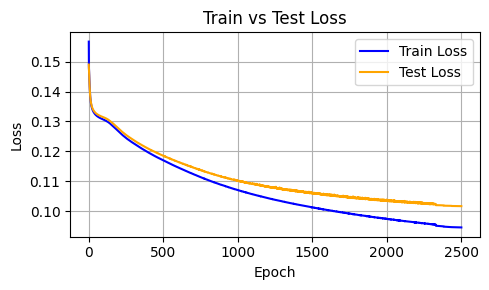

In [19]:
from IPython.display import clear_output

train_means, test_means = [], []
train_stds, test_stds = [], []
epochs = []

for epoch in range(n_epochs):
    train_losses = None
    test_dict = None
    
    train_losses = train_epoch(rnn, train_dataloader, loss_fn, optimizer)
    d = evaluate_rnn(DEVICE, rnn, test_dataloader, loss_fn, for_ratemaps=False)
    
    train_mean = np.mean(train_losses)

    test_losses = d['batch_losses']
    test_mean = np.mean(test_losses)

    scheduler.step(test_mean)

    train_means.append(train_mean)
    test_means.append(test_mean)

    # Clear previous plot output
    clear_output(wait=True)
    
    # Create new plot
    plt.figure(figsize=(5, 3))
    plt.plot(range(epoch+1), train_means, label='Train Loss', color='blue')
    plt.plot(range(epoch+1), test_means, label='Test Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Train and test loss for a ful training process.

![Train and test loss](train_test_loss.png)

In [20]:
torch.save(rnn.state_dict(), 'rnn.pth')

# load as
# rnn = PredictiveRNN(
#     DEVICE,
#     n_inputs=visual_embedding_dim + motion_signal_dim,
#     n_hidden=500,
#     n_outputs=visual_embedding_dim
# )
# rnn.load_state_dict(torch.load('rnn.pth', weights_only=True)).to(DEVICE)

### **Summary: what have we achieved?**

We defined and trained a custom **Recurrent Neural Network (RNN)**, presented as a model of the hippocampus.

We leveraged the **Dataset** and **DataLoader** Pytorch classes to define the self-supervised predictive task and generate sequential batches of data.

In the next part, we will explore the spatial representations of the neurons in the hidden state of the RNN.

### References

[1] J. O'keefe and L. Nadel. The hippocampus as a cognitive map. Oxford University Press, 1978.

[2] T. E. Behrens, T. H. Muller, J. C. Whittington, S. Mark, A. B. Baram, K. L. Stachenfeld, Z. Kurth-Nelson. What is a cognitive map? Organizing knowledge for flexible behavior. Neuron, 100(2):490-509, 2024.

[3] L. Acharya, Z. M. Aghajan, C. Vuong, J. J. Moore, and M. R. Mehta. Causal influence of visual cues on hippocampal directional selectivity. Cell, 164(1):197–207, 2016.

[4] K. J. Jeffery and J. M. O’Keefe. Learned interaction of visual and idiothetic cues in the control of place field orientation. Experimental brain research, 127:151–161, 1999.

[5] J. O'Keefe and D. H. Conway. Hippocampal place units in the freely moving rat: why they fire where they fire. Experimental brain research, 31:573–590, 1978.

[6] C. J. Cueva and X.-X. Wei. Emergence of grid-like representations by training recurrent neural networks to perform spatial localization. arXiv 1803.07770, 2018.

[7] J. Gornet and M. Thomson. Automated construction of cognitive maps with visual predictive coding. Nature Machine Intelligence, 6(7):820–833, 2024.

[8] D. Levenstein, A. Efremov, R. H. Eyono, A. Peyrache, and B. Richards. Sequential predictive learning is a unifying theory for hippocampal representation and replay. bioRxiv 2024.04.28.591528, 2024.

[9] S. Recanatesi, M. Farrell, G. Lajoie, S. Deneve, M. Rigotti, and E. Shea-Brown. Predictive learning as a network mechanism for extracting low-dimensional latent space representations. Nature communications, 12(1):1417, 2021.

[10] B. Uria, B. Ibarz, A. Banino, V. Zambaldi, D. Kumaran, D. Hassabis, C. Barry, and C. Blundell. The spatial memory pipeline: a model of egocentric to allocentric understanding in mammalian brains. BioRxiv 2020.11.11.378141, 2022.

[11] J. C. Whittington, T. H. Muller, S. Mark, G. Chen, C. Barry, N. Burgess, and T. E. Behrens. The tolman eichenbaum-machine: unifying space and relational memory through generalization in the hippocampal formation. Cell, 183(5):1249–1263, 2020.